In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torchdiffeq import odeint

from pit.dynamics.kinematic_bicycle_f110 import KinematicBicycle_Steer
from pit.integration import Euler, RK4
from pit.data_processor.csv_loader import fetch_aligned_trajectory_data

import matplotlib.pyplot as plt
import json
import math

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


## Helper Functions

In [61]:
class KinematicBicycle_Steer(nn.Module):
    """
    params_index = {
        "X": 0,
        "Y": 1,
        "DELTA": 2,
        "YAW": 3,
        "V": 4,
        "STEER": 0,
        "VEL": 1
    }
    """

    def __init__(self, lwb, st_delay, accel_delay, params_index) -> None:
        super().__init__()
        self.lwb = torch.nn.Parameter(torch.tensor(lwb, dtype=torch.float32))
        self.steer_delay_time = torch.nn.Parameter(torch.tensor(st_delay, dtype=torch.float32))
        self.accel_delay_time = torch.nn.Parameter(torch.tensor(accel_delay, dtype=torch.float32))
        self.accel_max = torch.nn.Parameter(torch.tensor(10.0, dtype=torch.float32))
        self.accel_min = torch.nn.Parameter(torch.tensor(-10.0, dtype=torch.float32))
        self.steer_k = torch.nn.Parameter(torch.tensor(1.0, dtype=torch.float32))
        self.steer_b = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.speed_k = torch.nn.Parameter(torch.tensor(1.0, dtype=torch.float32))
        # Define indexes for states and control inputs
        for key, value in params_index.items():
            setattr(self, key, value)
        # real U: steer, velocity
        # model U: steer_vel, accel.

    def forward(self, states, control_inputs):
        """ Get the evaluated ODEs of the state at this point

        Args:
            states (): Shape of (B, 5) or (5)
            control_inputs (): Shape of (B, 2) or (2)
        """
        batch_mode = True if len(states.shape) == 2 else False
        diff = torch.zeros_like(states)

        
        if batch_mode:
            steer = self.steer_k*states[:, self.DELTA] + self.steer_b
            desired_vel = control_inputs[:, self.VEL]*self.speed_k
            current_vel = states[:, self.V]
            accel = (desired_vel - current_vel) / self.accel_delay_time
            
            diff[:, self.X] = states[:, self.V] * torch.cos(states[:, self.YAW])
            diff[:, self.Y] = states[:, self.V] * torch.sin(states[:, self.YAW])
            diff[:, self.DELTA] = self.steer_k*(control_inputs[:, self.STEER] - states[:, self.DELTA]) / self.steer_delay_time
            diff[:, self.YAW] = (states[:, self.V] * torch.tan(steer)) / self.lwb
            diff[:, self.V] = torch.clamp(accel, self.accel_min, self.accel_max)
        else:
            steer = self.steer_k*states[self.DELTA] + self.steer_b
            desired_vel = control_inputs[self.VEL]*self.speed_k
            current_vel = states[self.V]
            accel = (desired_vel - current_vel) / self.accel_delay_time
            
            diff[self.X] = states[self.V] * torch.cos(states[self.YAW])
            diff[self.Y] = states[self.V] * torch.sin(states[self.YAW])
            diff[self.DELTA] = self.steer_k*(control_inputs[self.STEER] - states[self.DELTA]) / self.steer_delay_time
            # diff[YAW] = (states[V] * torch.tan(control_inputs[STEER])) / self.lwb
            diff[self.YAW] = (states[self.V] * torch.tan(steer)) / self.lwb
            diff[self.V] = torch.clamp(accel, self.accel_min, self.accel_max)
        return diff

In [8]:
X, Y, DELTA, YAW, V = 0, 1, 2, 3, 4
STEER, VEL = 0, 1


def kinematic_states_from_csv(traj_data: pd.DataFrame, cut_off):
    x = torch.tensor(traj_data['/pf/pose/odom/pose/pose/position/x'].to_numpy())[cut_off:]
    y = torch.tensor(traj_data['/pf/pose/odom/pose/pose/position/y'].to_numpy())[cut_off:]
    v = torch.tensor(traj_data['/odom/twist/twist/linear/x'].to_numpy())[cut_off:]
    yaw = torch.tensor(traj_data['/pf/pose/odom/pose/pose/orientation/yaw_deg'].to_numpy()*np.pi/180)[cut_off:]
    ti = torch.tensor(traj_data.index.to_numpy())[cut_off:]

    steer = torch.tensor(traj_data['/ackermann_cmd/drive/steering_angle'].to_numpy())[cut_off:]
    speed = torch.tensor(traj_data['/ackermann_cmd/drive/speed'].to_numpy())[cut_off:]
    return x, y, v, yaw, ti, steer, speed


def plot_gt_traj(traj_data, cut_off, horizon=None):
    x, y, v, yaw, ti, steer, speed = kinematic_states_from_csv(traj_data, cut_off)
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    # Plot for XY trajectory
    ax[0].plot(x, y, label='GT Trajectory', color='blue')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].set_title('XY Trajectory')
    ax[0].legend()
    ax[0].grid(True)
    ax[1].plot(ti, v, label='pred_v', color='blue')
    ax[1].plot(ti, v, label='gt_v', color='red')
    # ax[1][0].set_xlabel('Time')
    # ax[1][0].set_ylabel('Value')
    ax[1].legend()
    plt.tight_layout()
    plt.show()


def plot_states(pred, gt, ti, horizon=None):
    if horizon:
        pred = pred[:horizon, :]
        gt = gt[:horizon, :]
        ti = ti[:horizon]
    fig, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0][0].plot(ti, pred[:, DELTA], label='pred_steer', color='blue')
    ax[0][0].plot(ti, gt[:, DELTA], label='gt_steer', color='red')
    ax[0][0].legend()
    pred[:, YAW] = (pred[:, YAW] + math.pi) % (2 * math.pi) - math.pi
    ax[0][1].plot(ti, pred[:, YAW], label='pred_yaw', color='blue')
    ax[0][1].plot(ti, gt[:, YAW], label='gt_yaw', color='red')
    ax[0][1].legend()
    ax[1][0].plot(ti, pred[:, V], label='pred_v', color='blue')
    ax[1][0].plot(ti, gt[:, V], label='gt_v', color='red')
    # ax[1][0].set_xlabel('Time')
    # ax[1][0].set_ylabel('Value')
    ax[1][0].legend()

    # Plot for XY trajectory
    ax[1][1].plot(pred[:, 0], pred[:, 1], label='Pred Trajectory', color='blue')
    ax[1][1].plot(gt[:, 0], gt[:, 1], label='GT Trajectory', color='red')
    ax[1][1].set_xlabel('x')
    ax[1][1].set_ylabel('y')
    ax[1][1].set_title('XY Trajectory')
    ax[1][1].legend()
    ax[1][1].grid(True)

    plt.tight_layout()
    plt.show()

def batch_from_csv(traj_data, cut_off, device, step_gap=10, horizon=50):
    x, y, v, yaw, ti, steer, speed = kinematic_states_from_csv(traj_data, cut_off)

    initial_state = torch.tensor([x[0],y[0],steer[0],yaw[0],v[0]]).to(device)
    control_inputs = torch.vstack([steer, speed]).T
    control_inputs = control_inputs.contiguous().to(device)
    output_states = torch.vstack([x, y, steer, yaw, v]).T.to(device)
    target_states = output_states[1:]
    target_states = target_states.contiguous()

    STEP_GAP=step_gap
    HORIZON=horizon
    state_dims = initial_state.shape[0]
    input_dims = control_inputs.shape[-1]
    batch_size = (control_inputs.shape[0]-HORIZON-1)//STEP_GAP
    
    batched_timestamps = torch.zeros((batch_size, HORIZON, 1), device=DEVICE)
    batched_initial_states = torch.zeros((batch_size, state_dims), device=DEVICE)
    batched_control_inputs = torch.zeros((batch_size, HORIZON, input_dims), device=DEVICE)
    batched_target_states = torch.zeros((batch_size, HORIZON, state_dims), device=DEVICE)
    
    for step in range(batch_size):
        batched_initial_states[step] = output_states[step*STEP_GAP]
        batched_timestamps[step] = ti[:HORIZON].view(-1, 1) # Use fixed horizon for the timestamps
        # (10, 60), (20, 70), (30, 80)
        batched_control_inputs[step] = control_inputs[step*STEP_GAP:(step*STEP_GAP)+HORIZON]
        batched_target_states[step] = output_states[(step*STEP_GAP)+1:(step*STEP_GAP)+HORIZON+1]
    
    return batched_initial_states, batched_timestamps, batched_control_inputs, batched_target_states

## Load data from csv files

In [19]:
# 4_1, 4_2 does not have pf running
file_paths = ["../datasets/skir_1.csv", "../datasets/skir_2.csv", "../datasets/skir_3.csv", "../datasets/skir_4_3.csv"]
sample_interval = 0.04
cut_off = 20
step_gap = 5
horizon = 50

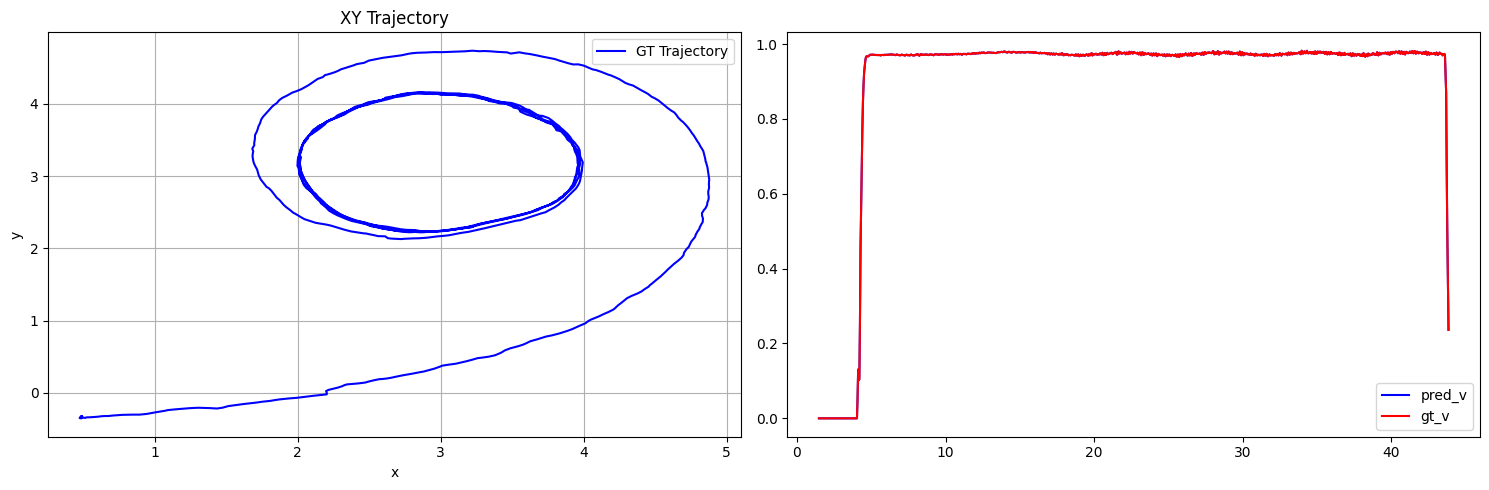

read batch data from../datasets/skir_1.csv, batch size201


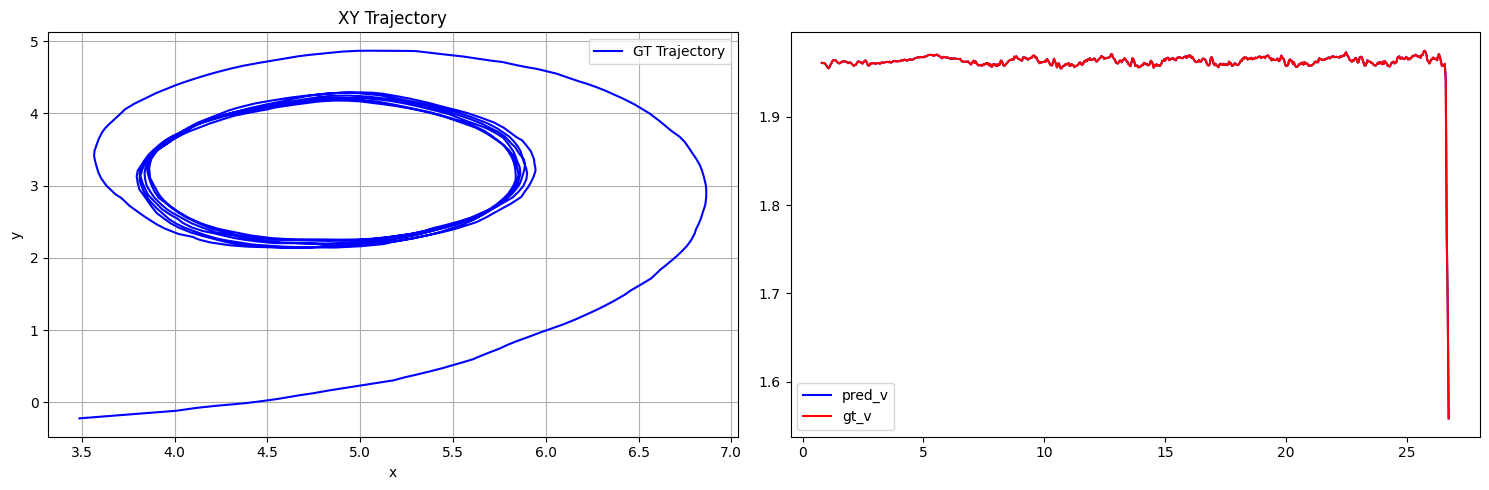

read batch data from../datasets/skir_2.csv, batch size119


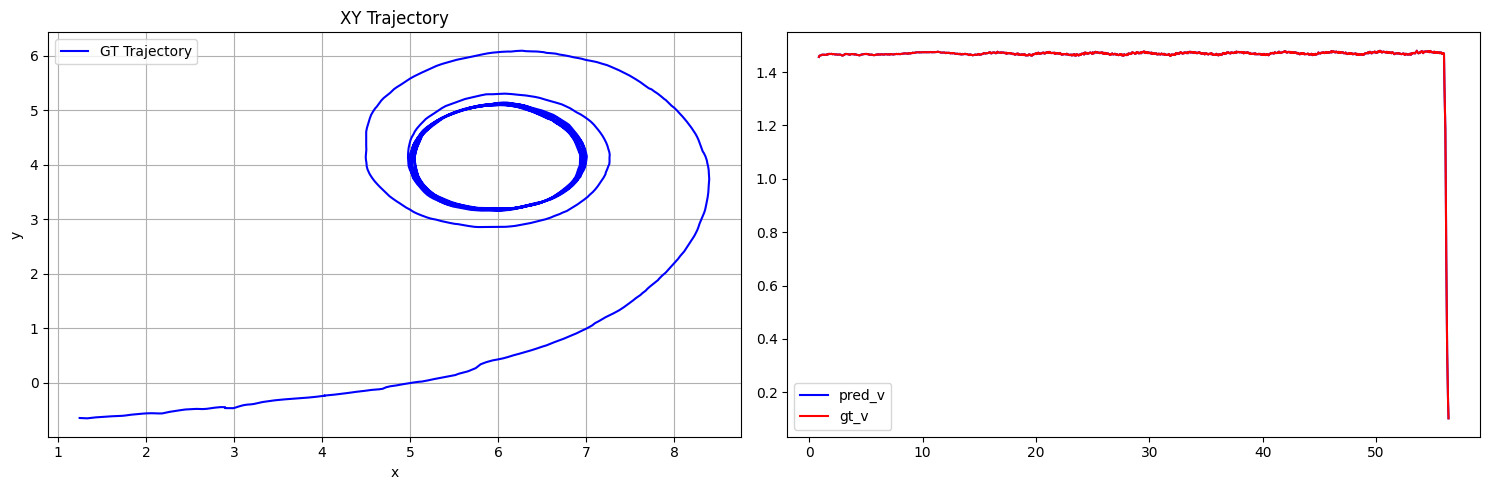

read batch data from../datasets/skir_3.csv, batch size267


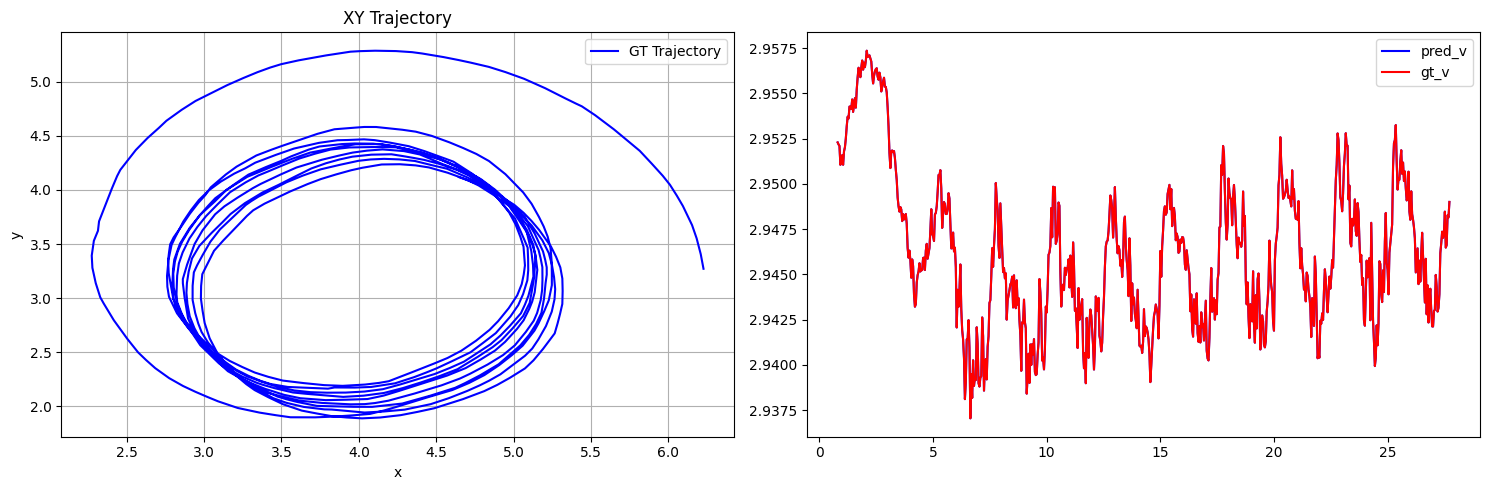

read batch data from../datasets/skir_4_3.csv, batch size124


In [20]:
# Initialize lists for concatenated data
all_initial_states = []
all_timestamps = []
all_control_inputs = []
all_target_states = []
for file_path in file_paths:
    traj_data = fetch_aligned_trajectory_data(file_path, sample_interval=sample_interval)
    batched_initial_states, batched_timestamps, batched_control_inputs, batched_target_states = \
           batch_from_csv(traj_data, cut_off, DEVICE, step_gap=step_gap, horizon=horizon)
    plot_gt_traj(traj_data, cut_off=cut_off)
    print(f"read batch data from{file_path}, batch size{batched_initial_states.shape[0]}")
    # Append each batched tensor to its corresponding list
    all_initial_states.append(batched_initial_states)
    all_timestamps.append(batched_timestamps)
    all_control_inputs.append(batched_control_inputs)
    all_target_states.append(batched_target_states)

# Concatenate all tensors in each list along the batch dimension
concatenated_initial_states = torch.cat(all_initial_states, dim=0)
concatenated_timestamps = torch.cat(all_timestamps, dim=0)
concatenated_control_inputs = torch.cat(all_control_inputs, dim=0)
concatenated_target_states = torch.cat(all_target_states, dim=0)

In [21]:
print(concatenated_initial_states.shape)

torch.Size([711, 5])


## Train

### Dataset Split

In [26]:
from torch.utils.data import TensorDataset, DataLoader, random_split

In [65]:
dataset = TensorDataset(concatenated_initial_states, concatenated_control_inputs, concatenated_target_states, concatenated_timestamps)

total_size = len(dataset)
test_size = int(total_size * 0.2)
train_size = total_size - test_size
print(f"training dataset size:{train_size}, testing dataset size:{test_size}")
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create the DataLoaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

training dataset size:569, testing dataset size:142


### View trajectory data

In [ ]:
# (1) MCMC, calculate difference between two distribution(add cov term)
# (2) Stochastic ODE

In [479]:
# with torch.no_grad():
#     pred = rk4_integrator(initial_state, control_inputs)
#     val_loss = kinematic_steer_loss(pred, output_states, params_index=params_index)
#     print(f"Initialized | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

Initialized | Validation Loss: 0.601844228253825 | LR: 0.003874204890000002


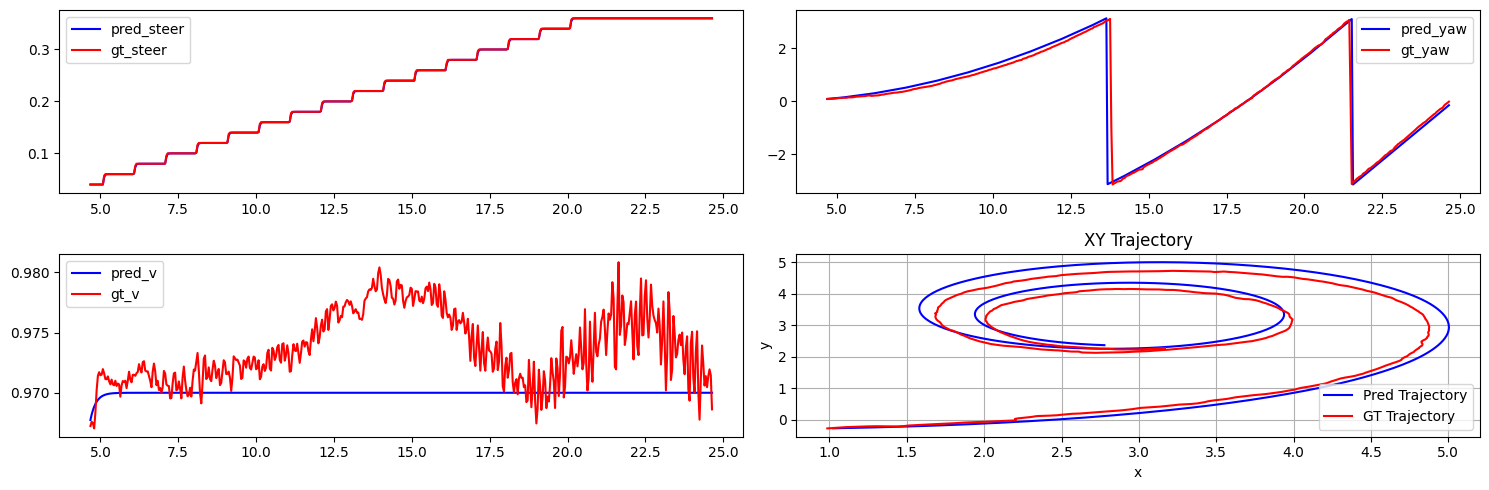

In [480]:
# plot_states(pred.cpu().detach().numpy(), output_states.cpu().detach().numpy(), ti, horizon=500)

### Model Definition

In [76]:
params_index = {
    "X": 0,
    "Y": 1,
    "DELTA": 2,
    "YAW": 3,
    "V": 4,
    "STEER": 0,
    "VEL": 1
}
kinematic_f110 = KinematicBicycle_Steer(lwb=0.31, st_delay=0.05, accel_delay=0.2, params_index=params_index).to(DEVICE)
kinematic_f110.lwb.requires_grad = False
kinematic_f110.steer_delay_time.requires_grad = False
kinematic_f110.accel_delay_time.requires_grad = False
kinematic_f110.accel_max.requires_grad = False
kinematic_f110.accel_min.requires_grad = False
kinematic_f110.steer_k.requires_grad = True
kinematic_f110.steer_b.requires_grad = False
# euler_integrator = Euler(kinematic_f110, timestep=sample_interval)
rk4_integrator = RK4(kinematic_f110, timestep=sample_interval)


def kinematic_steer_loss(pred, target, params_index):
    X, Y, YAW, V = params_index["X"], params_index["Y"], params_index["YAW"], params_index["V"]
    indices = [X, Y, V]
    pred_selected = pred[..., indices]
    target_selected = target[..., indices]
    # NOTE: can not modify the varibale inplace, so yaw is regularized separately
    regularize_yaw =  (pred[..., YAW] + math.pi) % (2 * math.pi) - math.pi

    # Compute the L1 loss
    # return torch.abs(pred_selected - target_selected).mean() + torch.abs(regularize_yaw - target[..., YAW]).mean()
    return torch.abs(pred_selected - target_selected).mean()

### Example from test_dataset with original parameter

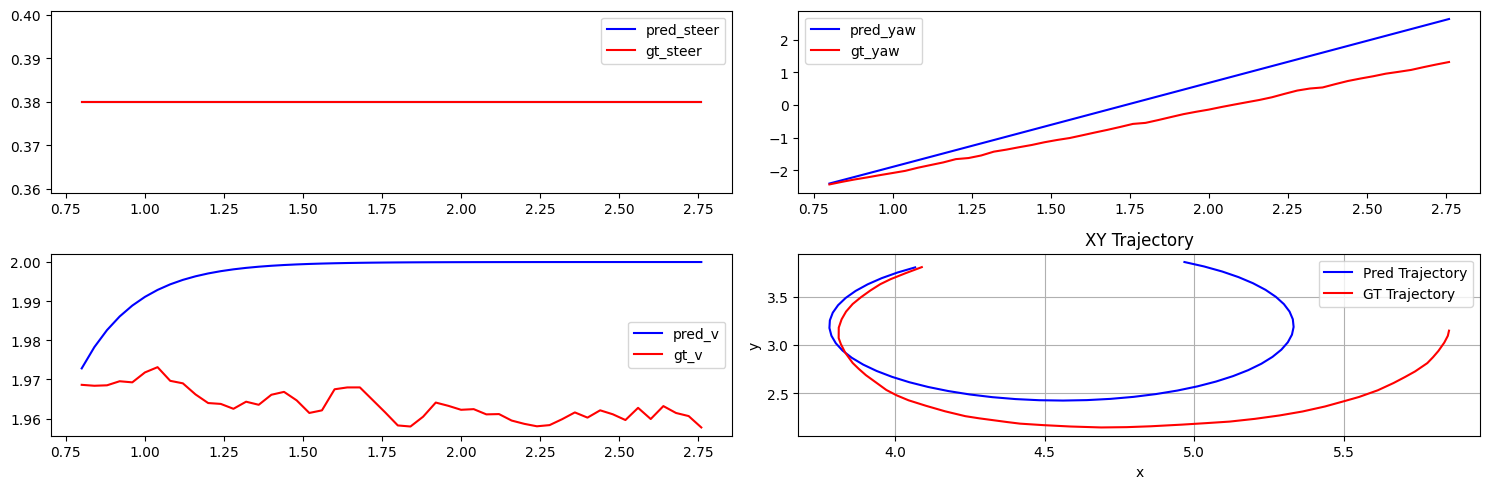

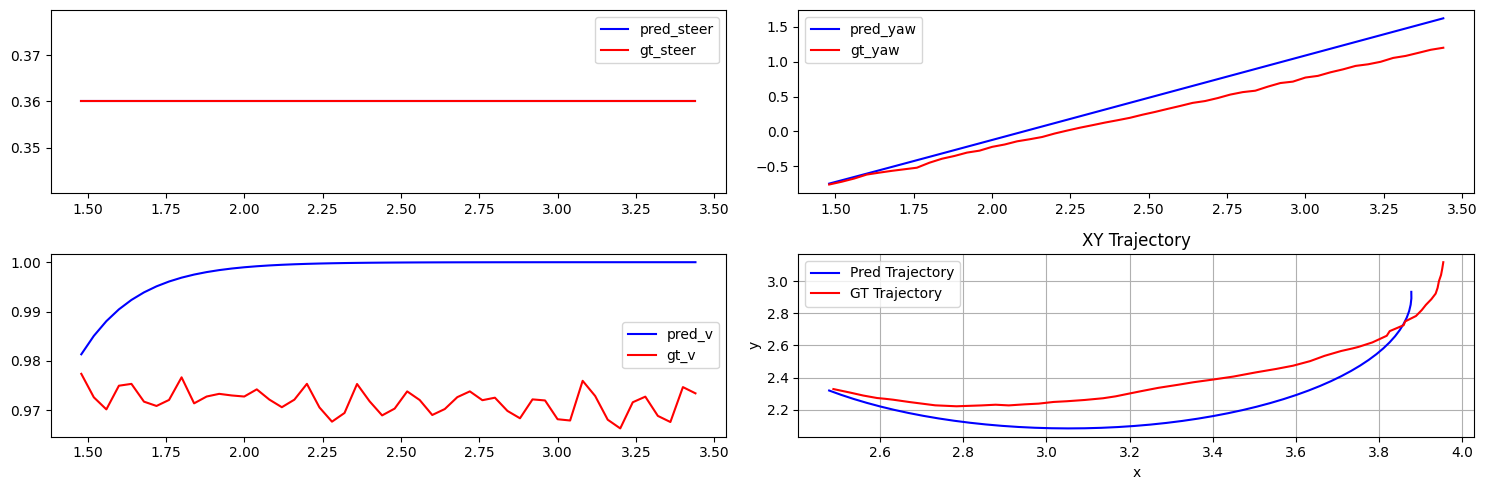

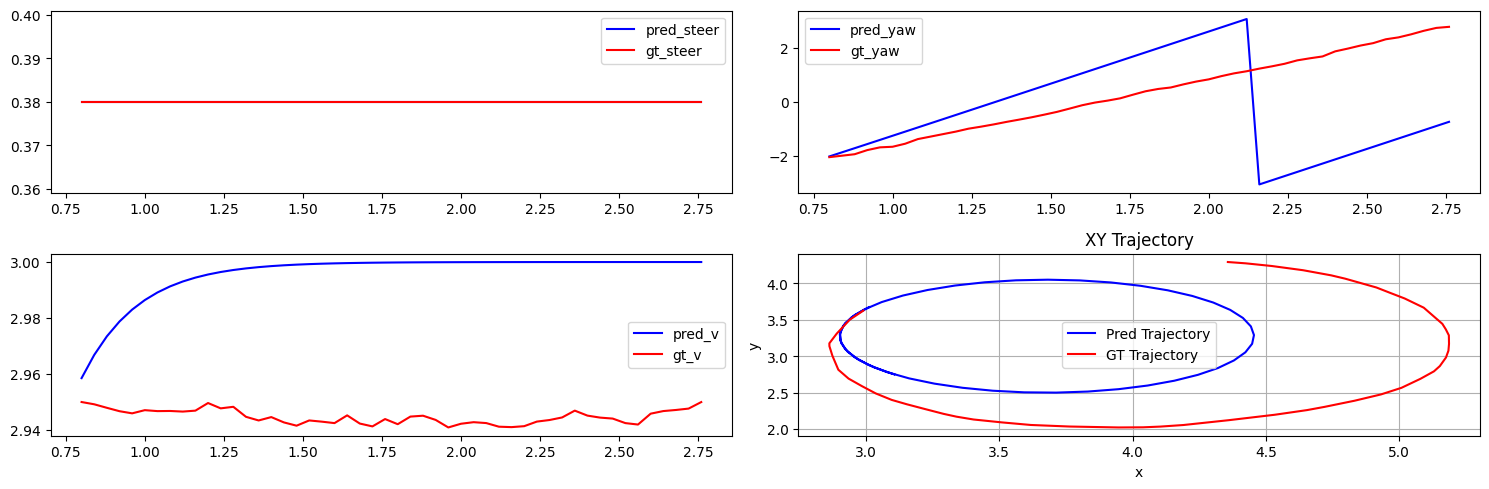

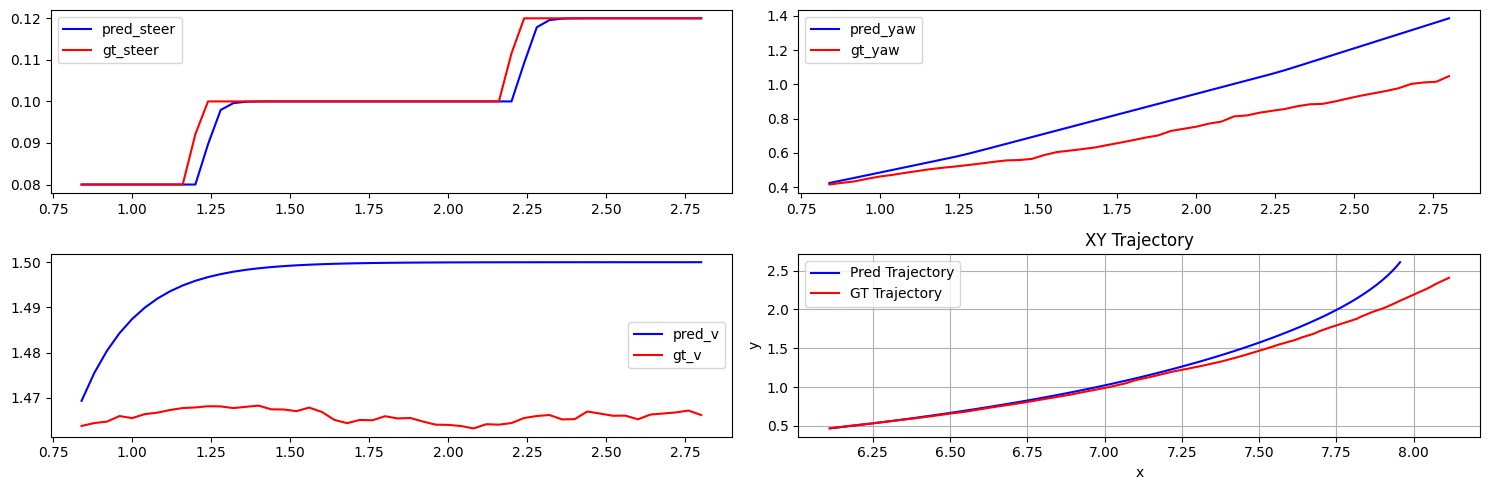

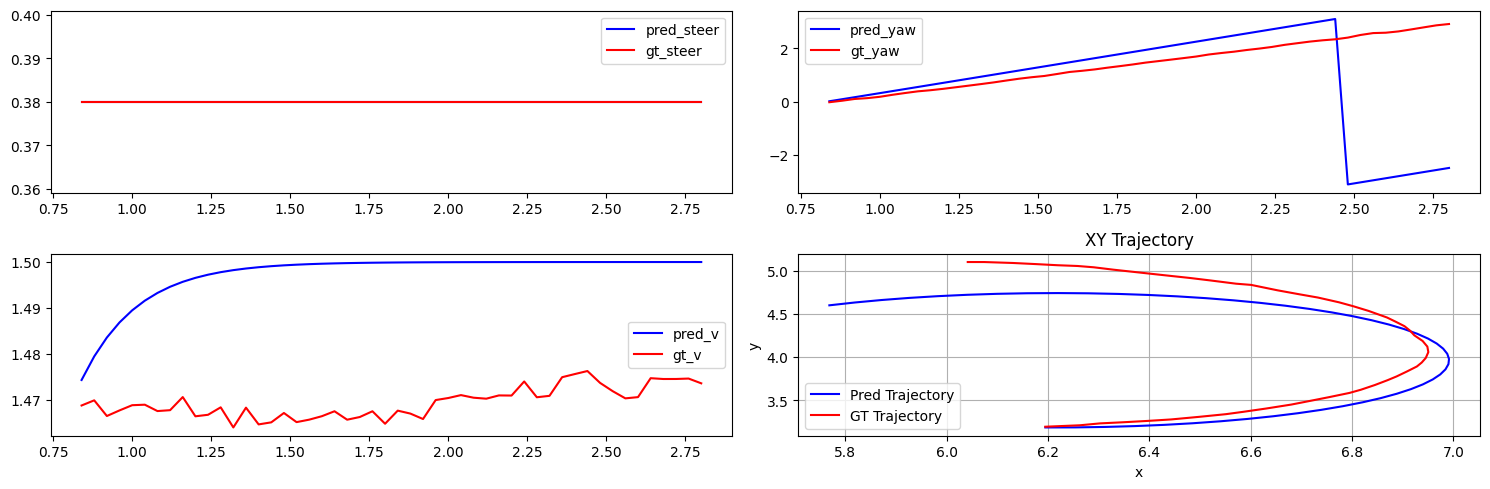

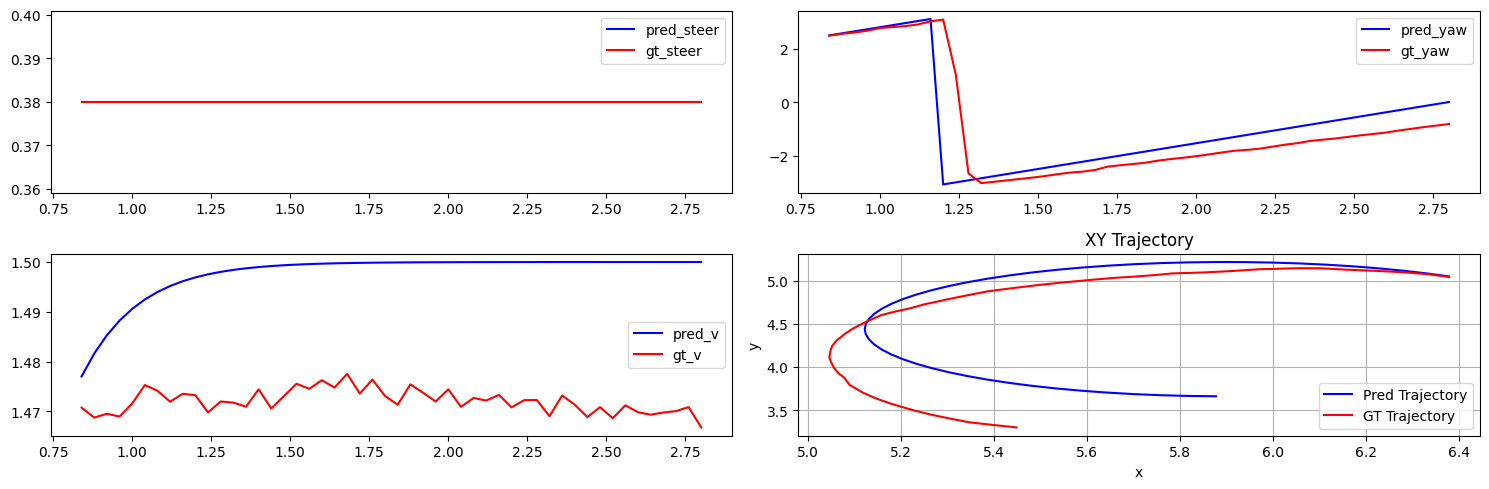

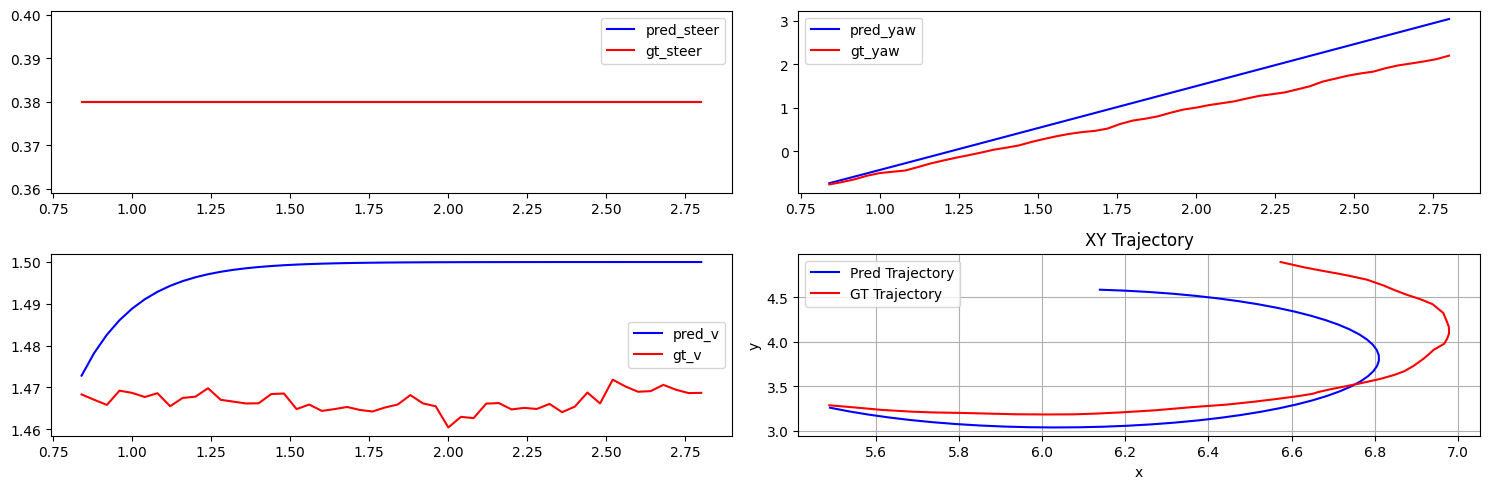

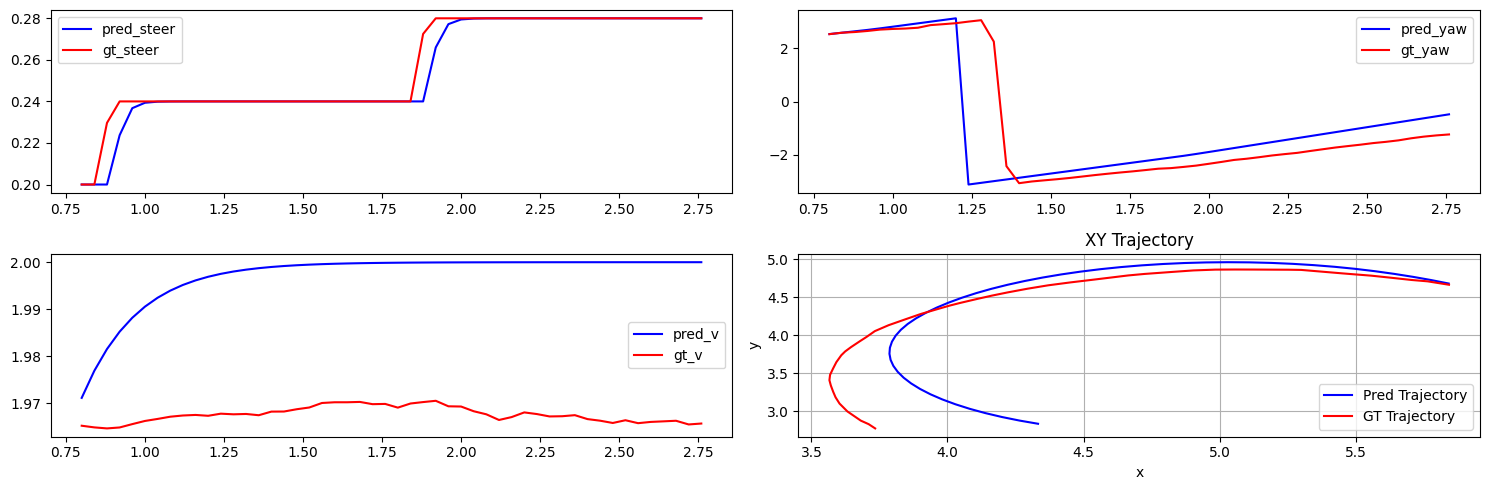

In [77]:
with torch.no_grad():
    val_loss = 0.0
    for initial, inputs, targets, timestamps in test_dataloader:
        pred_states = rk4_integrator(initial, inputs)
        batch_val_loss = kinematic_steer_loss(pred_states, targets, params_index=params_index)
        for i in range(len(pred_states)):
            if i%20==0:
                plot_states(pred_states[i].cpu().detach().numpy(), targets[i].cpu().detach().numpy(), timestamps[i].cpu().detach().numpy())

In [78]:
from tqdm.auto import tqdm
EPOCHS = 30
optimizer = torch.optim.SGD(kinematic_f110.parameters(), lr=0.005, momentum=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.9)

In [79]:
train_losses = []
val_losses = []
lrs = []
# torch.autograd.set_detect_anomaly(False)
for i in tqdm(range(EPOCHS)):
    # Evaluation on test dataset
    for name, param in kinematic_f110.named_parameters():
       if param.requires_grad:
           print(name, param.data, param.grad)
        # plot_states(pred_states[0].cpu().detach().numpy(), targets[0].cpu().detach().numpy(), timestamps[0])
        # print(f"Epoch: {i} | Training Loss: {loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    for initial, inputs, targets, timestamps in train_dataloader:
        optimizer.zero_grad()
        pred_states = rk4_integrator(initial, inputs)
        loss = kinematic_steer_loss(pred_states, targets, params_index=params_index)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        val_loss = 0.0
        for initial, inputs, targets, timestamps in test_dataloader:
            pred_states = rk4_integrator(initial, inputs)
            batch_val_loss = kinematic_steer_loss(pred_states, targets, params_index=params_index)
            val_loss += batch_val_loss.item()
    print(f"Epoch: {i} | Training Loss: {loss.item()} | LR: {optimizer.param_groups[0]['lr']} | Val loss: {val_loss:.4f}")
    lrs.append(optimizer.param_groups[0]['lr'])
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    scheduler.step(val_loss)

  0%|          | 0/30 [00:00<?, ?it/s]

steer_k tensor(1., device='cuda:0') None
speed_k tensor(1., device='cuda:0') None
Epoch: 0 | Training Loss: 0.14956900477409363 | LR: 0.005 | Val loss: 0.3344
steer_k tensor(0.9615, device='cuda:0') tensor(0.2870, device='cuda:0')
speed_k tensor(0.9755, device='cuda:0') tensor(-0.4049, device='cuda:0')
Epoch: 1 | Training Loss: 0.16526688635349274 | LR: 0.005 | Val loss: 0.3059
steer_k tensor(0.9144, device='cuda:0') tensor(0.1750, device='cuda:0')
speed_k tensor(0.9808, device='cuda:0') tensor(-0.1658, device='cuda:0')
Epoch: 2 | Training Loss: 0.1297392100095749 | LR: 0.005 | Val loss: 0.2961
steer_k tensor(0.8864, device='cuda:0') tensor(-0.1280, device='cuda:0')
speed_k tensor(0.9823, device='cuda:0') tensor(0.0651, device='cuda:0')
Epoch: 3 | Training Loss: 0.1450241357088089 | LR: 0.005 | Val loss: 0.2936
steer_k tensor(0.8798, device='cuda:0') tensor(-0.0299, device='cuda:0')
speed_k tensor(0.9801, device='cuda:0') tensor(-0.1172, device='cuda:0')
Epoch: 4 | Training Loss: 0.135

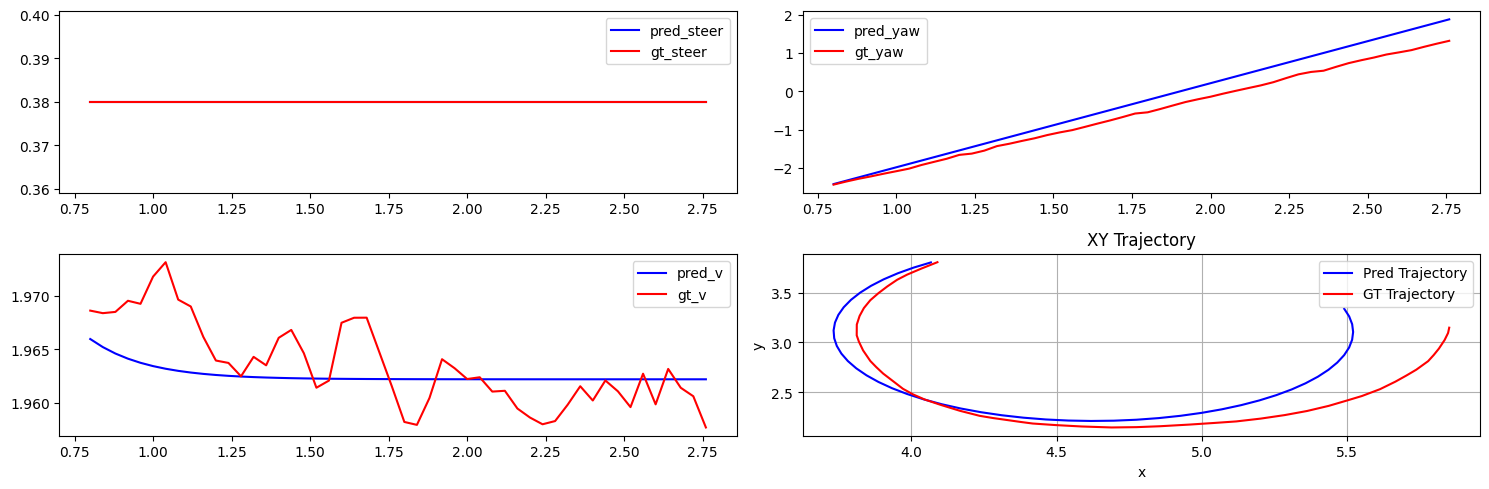

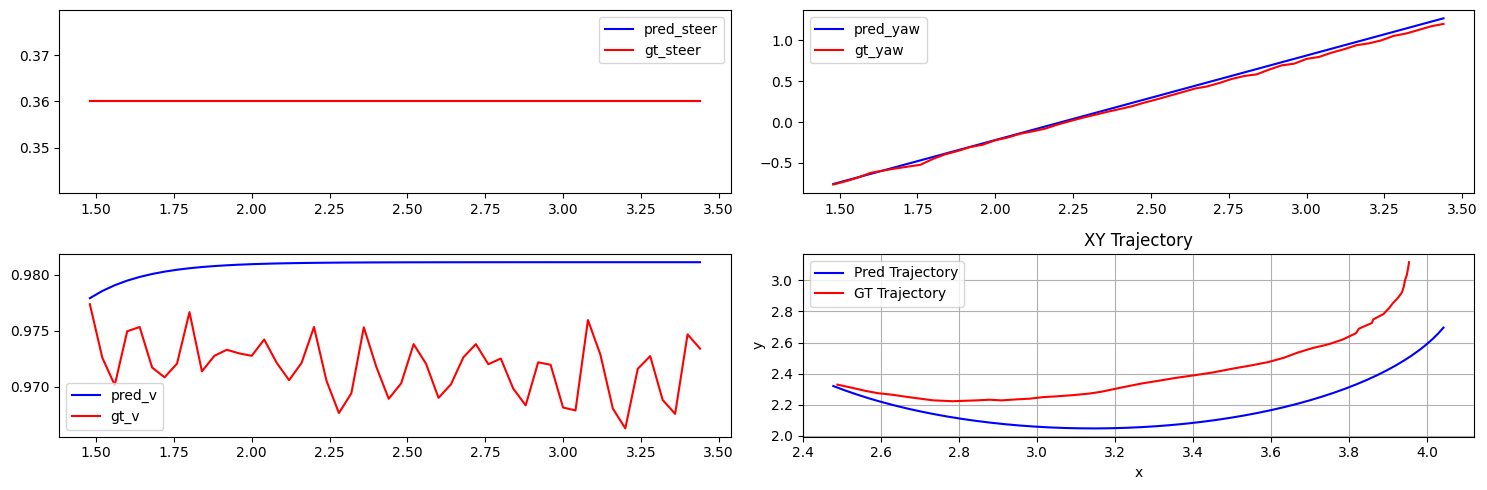

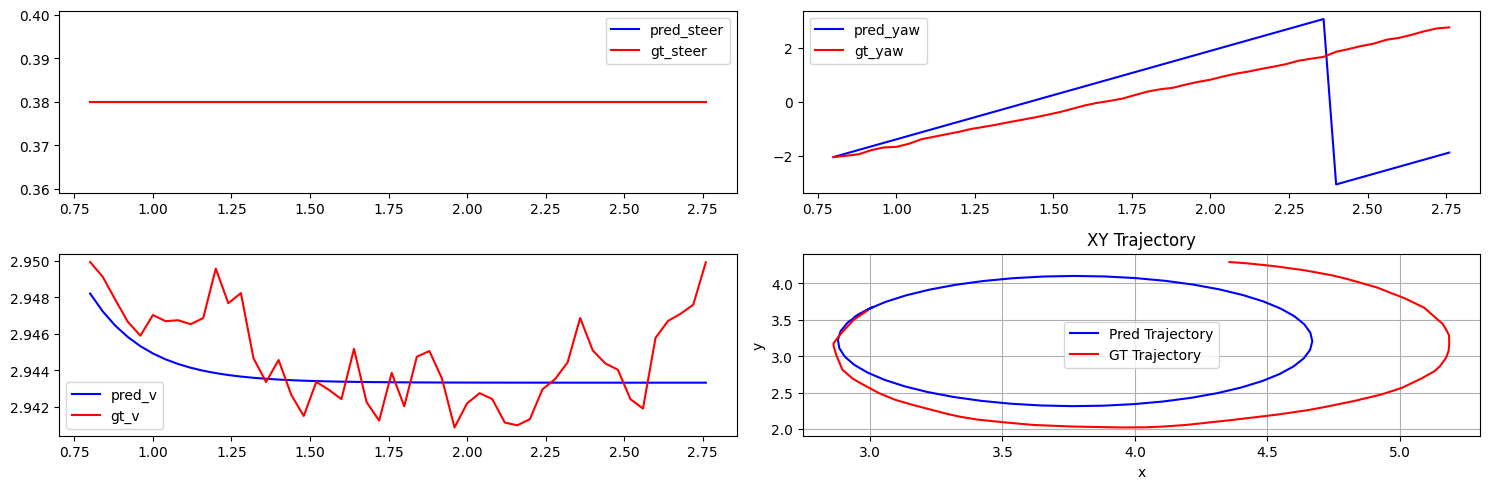

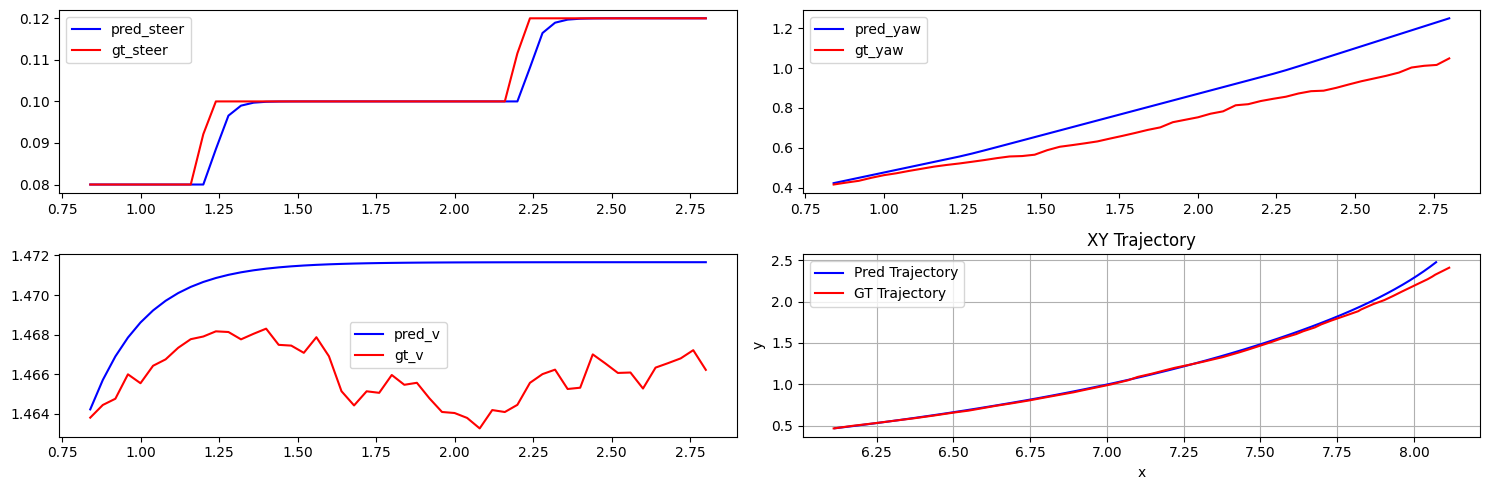

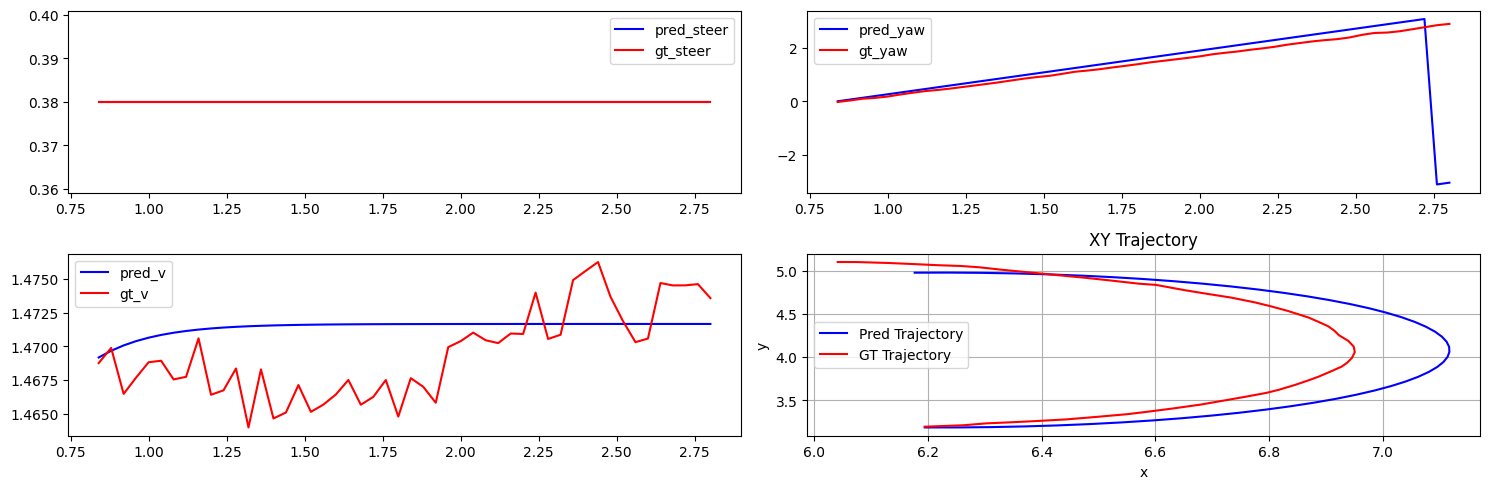

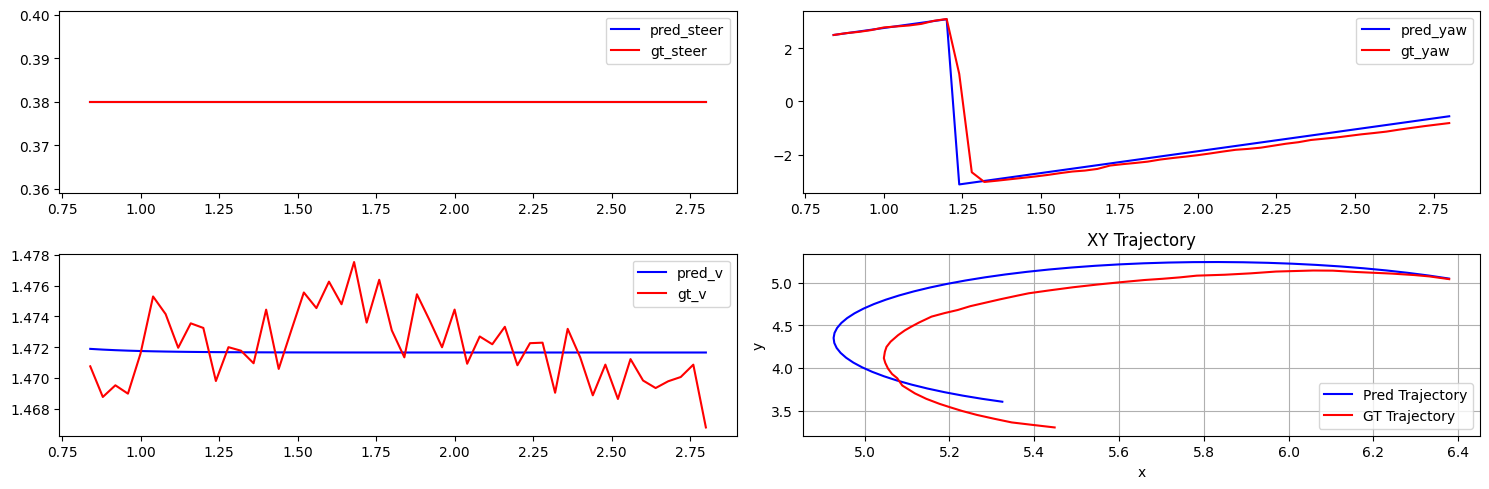

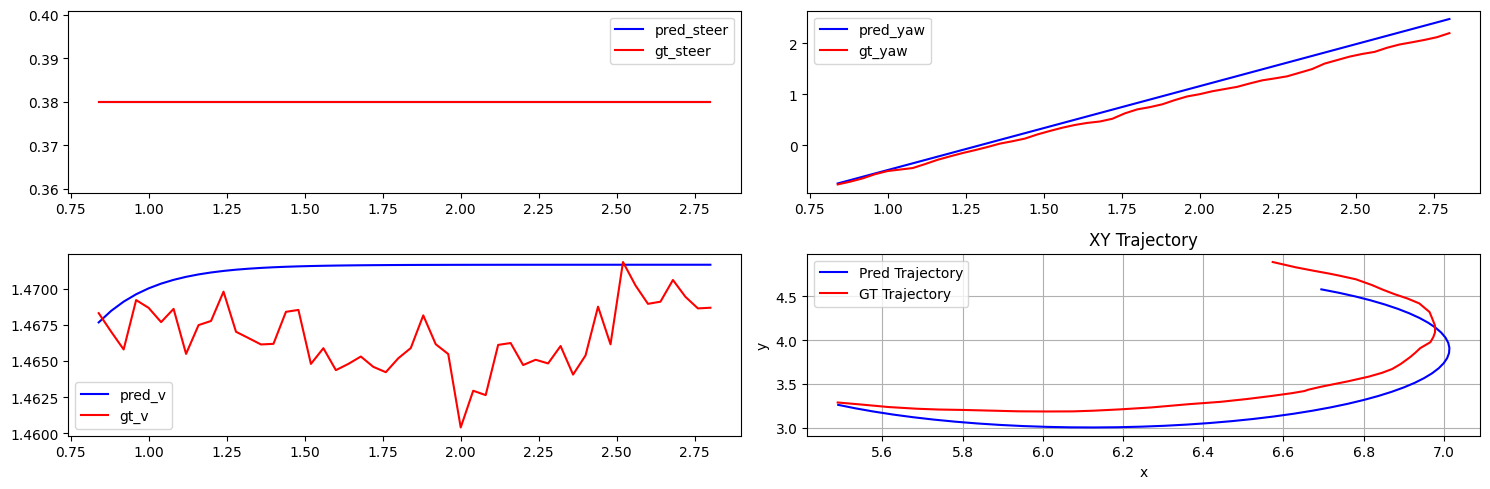

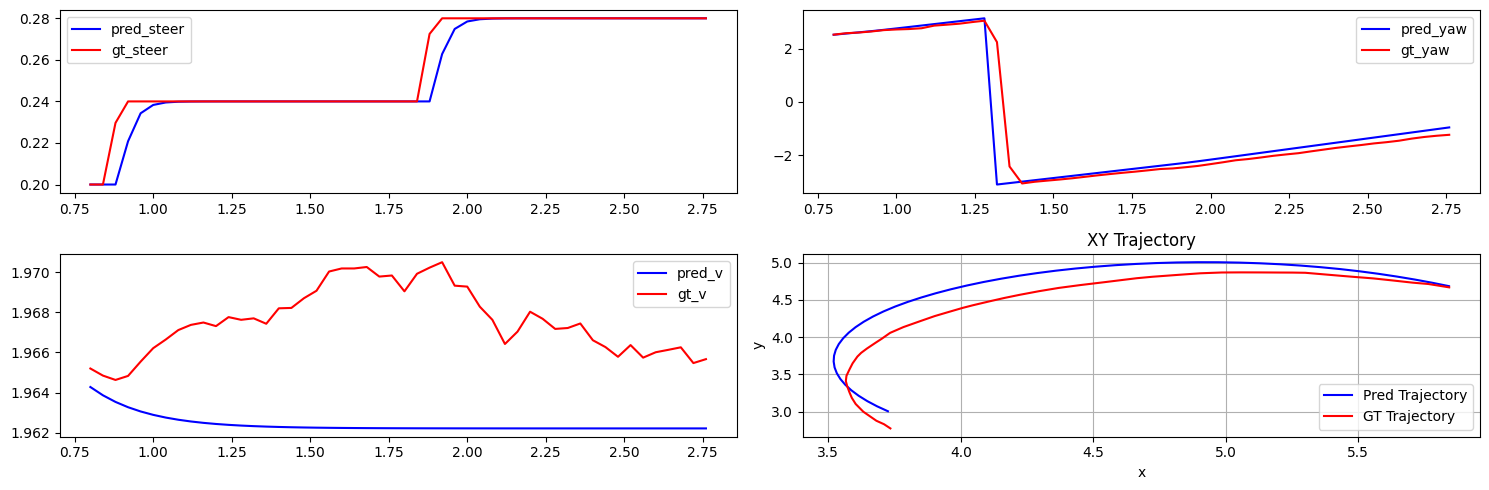

In [80]:
with torch.no_grad():
    val_loss = 0.0
    for initial, inputs, targets, timestamps in test_dataloader:
        pred_states = rk4_integrator(initial, inputs)
        batch_val_loss = kinematic_steer_loss(pred_states, targets, params_index=params_index)
        for i in range(len(pred_states)):
            if i%20==0:
                plot_states(pred_states[i].cpu().detach().numpy(), targets[i].cpu().detach().numpy(), timestamps[i].cpu().detach().numpy())